# MIPT course "Introduction to ML and DL".

## Practical assignment N1: neural networks basics
1. **Start date**: 23 Mar 2017 (Lecture N5 of the course).
2. **Deadline**: 5 Apr 2017. Send name and link to github repo which contains solutions in annotated .ipynb file to kretovmk@gmail.com (solutions should be clearly marked: part A, part B etc).

All tasks are connected with training simple networks. Example of implementation of backpropagation algorithms is provided in module model_numpy. You can add new layers and activation functions by writing corresponding classes. Assignment consists of 3 major parts:

1. Toy dataset "moons" from sklearn. Following methods for training neural network's weights are covered: Random search, Cross-entropy method, Batch gradient descent.
2. Toy dataset MNIST. Networks implemented using Keras, pure Tensorflow and Numpy.
3. Getting intuition behind architectures of neural networks.


## Specific description of assignment

### Part A

Toy "moons" dataset, for creating networks use module model_numpy.

1. Use following network: input(dim=2) --> hidden_tanh(dim=10) --> output_softmax(dim=2) and train it using different techniques. Accuracy target: 75% for 1000 training points. Launch 100 random initializations of weights and take average training time. Training methods: random search (to be implemented by you), CEM (to be implemented by you), batch gradient descent (code is partially implemented, review it for usage in Part B). Use Python multiprocessing module for implementation of CEM and random search.
2. Replace tanh activation in the network from p.1 with ReLU activation. You will need to write additional class for activation function. Compare time for forward pass (1000 training points) with network from p.1.


### Part B

MNIST dataset, for creating networks use module model_numpy, Tensorflow and Keras with different backends.

1. Create following network: input(784) --> hidden_tanh(200) --> output_softmax(10) train using batch gradient descent.
2. Review the same network as in p.1 implemented using pure Tensorflow and compare forward pass time. Read tutorial [5] or optional refs (see below). 
3. Implement the same network as in p.1 using Keras with different backends (Theano, Tensorflow) and compare forward pass time. Before that may need to read tutorial [4] or optional refs (see below).
4. Try different weights initializations, compare results.

### Part C

Play with visualized neural networks to get "intuition" behind simple architectures: 
* http://playground.tensorflow.org/
* http://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html

Read blog article with simple examples of connections between NN architecture and capacity:
* http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/

## References

1. Backpropagation algorithm: https://neuralnetworksanddeeplearning.com/
2. Backpropagation algorithm: http://cs231n.github.io/optimization-2/
3. Backpropagation algorithm: http://neuralnetworksanddeeplearning.com/chap2.html (very simple and intuitive explanation)
4. CEM (slide 11): https://people.eecs.berkeley.edu/~pabbeel/nips-tutorial-policy-optimization-Schulman-Abbeel.pdf
5. Keras tutorial: https://keras.io/
6. Tensorflow tutorial: https://www.tensorflow.org/get_started/mnist/beginners

Optional: 

1. NVIDIA/MIT course on DL/Tensorflow (see session 2): http://introtodeeplearning.com/ 
2. Stanford course on DL/Tensorflow (see lectures 1-2): http://web.stanford.edu/class/cs20si/syllabus.html
3. Book: TensorFlow for Machine Intelligence

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Assignment a1: toy dataset "moons" (training by different techniques)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from models.model_numpy import SoftmaxNetwork, FullyConnectedLayer
from utils import Sigmoid, Softmax, Tanh, init_weights, plot_decision_boundary

##### generating dataset

In [3]:
# dataset generating options
N = 1000
noise = 0.3
input_dim = 2

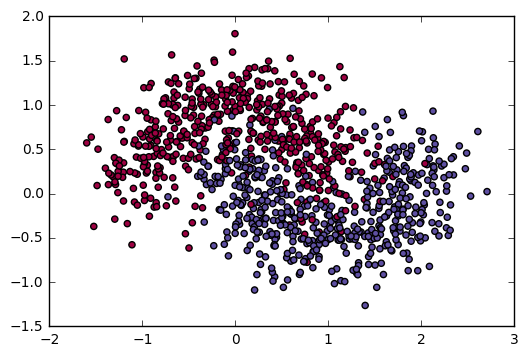

In [4]:
# generating dataset
np.random.seed(0)
x, y_tar = make_moons(n_samples=N, noise=noise)
plt.scatter(x[:, 0], x[:, 1], s=20, c=y_tar, cmap=plt.cm.Spectral)
plt.show()

In [5]:
# creating layers for the network
seed = np.random.randint(1e6)
def build_simple_network():
    np.random.seed(seed)
    hid_layers = [FullyConnectedLayer(input_dim=2, hidden_dim=10, act_func=Tanh(), w_initializer=init_weights),
                 FullyConnectedLayer(input_dim=10, hidden_dim=2, act_func=Softmax(), w_initializer=init_weights)]
    return SoftmaxNetwork(hid_layers)

accuracy: 0.341


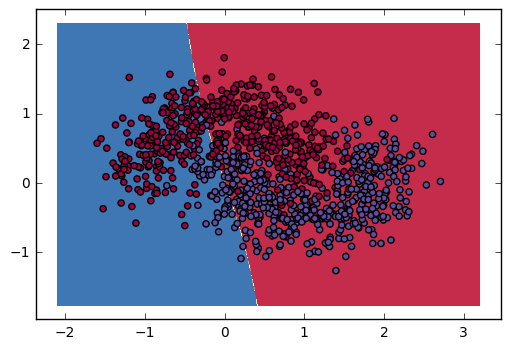

In [6]:
# decision boundary for non-trained network
network_numpy = build_simple_network()
y_pred = network_numpy.predict(x)
print 'accuracy: {:.3f}'.format(accuracy_score(y_true=y_tar, y_pred=y_pred))
plot_decision_boundary(x, y_tar, network_numpy.predict)

In [7]:
from tqdm import tqdm
from models.opt_derivative_free import mult_random_search, mult_cem

def f(params):
    network_numpy.set_params_from_flatten_array(params)
    return network_numpy.calc_accuracy(x, y_tar)

##### Random search

100%|██████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.93it/s]


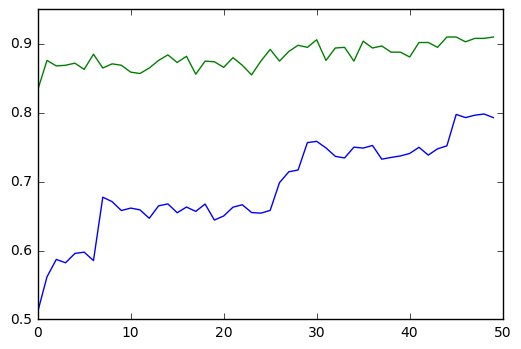

Last iteration. Average accuracy in batch: 79.30%; Accuracy with best weights: 91.00%


In [8]:
# training
network_numpy = build_simple_network()
params_mean = np.zeros(network_numpy.n_params)
av_acc, max_acc = [], []
n_iter = 50
res_rs = mult_random_search(f, params_mean, params_std=1., n_workers=4, batch_size=200, n_iter=n_iter)
for i in tqdm(xrange(n_iter)):
    res = next(res_rs)
    av_acc.append(res['results'].mean())
    max_acc.append(np.max(res['results']))
plt.plot(av_acc)
plt.plot(max_acc)
plt.show()
print 'Last iteration. Average accuracy in batch: {:.2f}%; Accuracy with best weights: {:.2f}%'\
                                                                      .format(av_acc[-1]*100, max_acc[-1]*100)

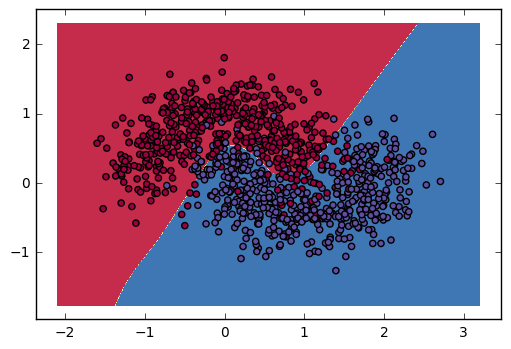

In [9]:
# decision boundary
best_weights = res['best_params']
network_numpy.set_params_from_flatten_array(best_weights)
plot_decision_boundary(x, y_tar, network_numpy.predict)
plt.show()

##### CEM

100%|██████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  5.90it/s]


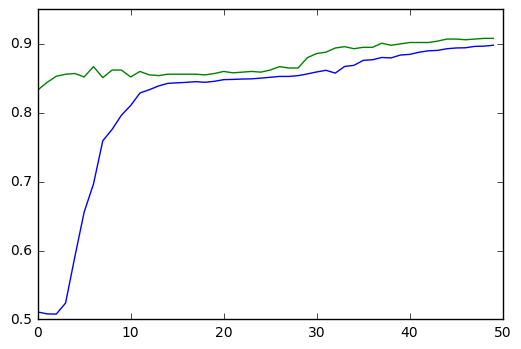

Last iteration. Average accuracy in batch: 89.80%; Accuracy with best weights: 90.80%


In [10]:
# training
network_numpy = build_simple_network()
params_mean = np.zeros(network_numpy.n_params)
av_acc, max_acc = [], []
n_iter = 50
res_rs = mult_cem(f, params_mean, params_std=1., n_workers=4, batch_size=200, n_iter=n_iter)
for i in tqdm(xrange(n_iter)):
    res = next(res_rs)
    av_acc.append(res['results'].mean())
    max_acc.append(np.max(res['results']))
plt.plot(av_acc)
plt.plot(max_acc)
plt.show()
print 'Last iteration. Average accuracy in batch: {:.2f}%; Accuracy with best weights: {:.2f}%'\
                                                                      .format(av_acc[-1]*100, max_acc[-1]*100)

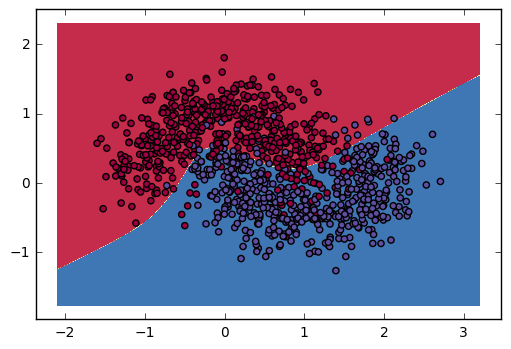

In [11]:
# decision boundary
best_weights = res['best_params']
network_numpy.set_params_from_flatten_array(best_weights)
plot_decision_boundary(x, y_tar, network_numpy.predict)
plt.show()

##### batch gradient

  0%|                                                                      | 0/400 [00:00<?, ?it/s]utils.py:38: RuntimeWarning: overflow encountered in power
  return (1 - np.power(x, 2))
utils.py:38: RuntimeWarning: invalid value encountered in power
  return (1 - np.power(x, 2))
100%|███████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 314.96it/s]


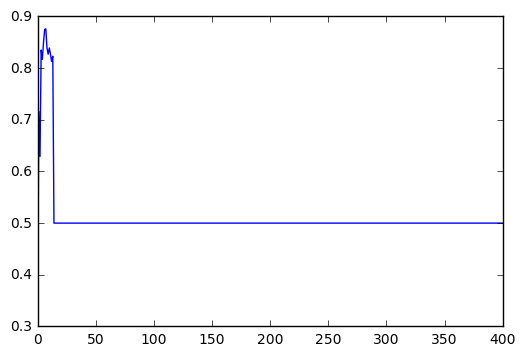

Accuracy with last weights: 50.00%


In [12]:
# training
network_numpy = build_simple_network()
acc = [network_numpy.calc_accuracy(x, y_tar)]
n_iter = 400
for i in tqdm(xrange(n_iter)):
    network_numpy.update_weights(x=x, y_tar=y_tar, eps=1.)
    acc.append(network_numpy.calc_accuracy(x, y_tar))
plt.plot(acc)
plt.show()
print 'Accuracy with last weights: {:.2f}%'.format(acc[-1]*100)

In [ ]:
# decision boundary
plot_decision_boundary(x, y_tar, network_numpy.predict)
plt.show()

### Assignment a2: MNIST dataset (training by batch gradient descent)

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

from tqdm import tqdm
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from models.model_numpy import SoftmaxNetwork, FullyConnectedLayer
from utils import Sigmoid, Softmax, Tanh, init_weights, plot_decision_boundary
from tensorflow.examples.tutorials.mnist import input_data

##### options

In [ ]:
N_CLASSES = 10  # number of classes in MNIST (ten digits)
N_HID = 200  # number of hidden neurons
N_EPOCHS = 20

##### numpy model

In [ ]:
seed = np.random.randint(1e6)
def build_network():
    np.random.seed(seed)
    hid_layers = [FullyConnectedLayer(input_dim=784, hidden_dim=N_HID, act_func=Tanh(), w_initializer=init_weights),
                 FullyConnectedLayer(input_dim=N_HID, hidden_dim=10, act_func=Softmax(), w_initializer=init_weights)]
    return SoftmaxNetwork(hid_layers)

In [ ]:
# loading dataset
# first time it may take a while to download dataset in the local folder
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
x_images = mnist.train.images
y_tar = np.argmax(mnist.train.labels, axis=1)

In [ ]:
# building network
network_numpy = build_network()

In [ ]:
# training
acc = []
times = []
for i in tqdm(xrange(N_EPOCHS)):
    t = time.time()
    network_numpy.update_weights(x=x_images, y_tar=y_tar, eps=1.0)
    times.append(time.time() - t)
    cur_acc = network_numpy.calc_accuracy(x_images, y_tar)
    acc.append(cur_acc)
plt.plot(acc)
plt.show()
print 'Accuracy with last weights on train set: {:.2f}%, Average time on epoch: {:.2f} sec'\
                                                                  .format(acc[-1]*100, np.array(times).mean())

##### tensorflow model

In [ ]:
# loading dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
x_images = mnist.train.images
y_tar = mnist.train.labels

In [ ]:
# building network
tf.reset_default_graph()
with tf.name_scope('data'):
    x = tf.placeholder(tf.float32, [None, 784], name='images')
    y = tf.placeholder(tf.float32, [None, 10], name='labels')
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
with tf.variable_scope('fc') as scope:
    w = tf.get_variable('weights', [784, N_HID], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('biases', [N_HID], initializer=tf.random_normal_initializer())
    fc = tf.nn.tanh(tf.matmul(x, w) + b, name='relu')
with tf.variable_scope('softmax_linear') as scope:
    w = tf.get_variable('weights', [N_HID, 10], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('biases', [10], initializer=tf.random_normal_initializer())
    logits = tf.matmul(fc, w) + b
with tf.name_scope('loss'):
    entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(entropy, name='loss')
optimizer = tf.train.GradientDescentOptimizer(1.).minimize(loss, global_step=global_step)
predictions = tf.nn.softmax(logits)
correct_preds = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [ ]:
# training
acc = []
times = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    initial_step = global_step.eval()
    for _ in tqdm(xrange(N_EPOCHS)):
        t = time.time()
        _, _, cur_acc = sess.run([optimizer, loss, accuracy], feed_dict={x: x_images, y: y_tar})
        acc.append(cur_acc)
        times.append(time.time() - t)
plt.plot(acc)
plt.show()
print 'Accuracy with last weights on train set: {:.2f}%, Average time on epoch: {:.2f} sec'\
                                                                  .format(acc[-1]*100, np.array(times).mean())

##### keras model

In [ ]:
# TO BE IMPLEMENTED